In [1]:
from numpy.random import seed
seed(101)
from tensorflow import set_random_seed
set_random_seed(101)

import pandas as pd
import numpy as np


import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Dense, Dropout, Flatten, Activation
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import Adam

import os
import cv2

from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import itertools
import shutil
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:

IMAGE_SIZE = 96
IMAGE_CHANNELS = 3

SAMPLE_SIZE = 80000 


In [3]:
os.listdir('../input/histopathologic-cancer-detection')

['sample_submission.csv', 'train_labels.csv', 'test', 'train']



0 = no met tissue<br>
1 =   has met tissue. <br>


In [4]:

print(len(os.listdir('../input/histopathologic-cancer-detection/train')))


220025


In [5]:
df_data = pd.read_csv('../input/histopathologic-cancer-detection/train_labels.csv')

# removing an erroneous image
df_data = df_data[df_data['id'] != 'dd6dfed324f9fcb6f93f46f32fc800f2ec196be2']

# removing an erroneous image
df_data = df_data[df_data['id'] != '9369c7278ec8bcc6c880d99194de09fc2bd4efbe']


print(df_data.shape)

(220023, 2)


In [6]:
df_data['label'].value_counts()

0    130907
1     89116
Name: label, dtype: int64

### Display a random sample of train images  by class

In [7]:
# source: https://www.kaggle.com/gpreda/honey-bee-subspecies-classification

def draw_category_images(col_name,figure_cols, df, IMAGE_PATH):
    
    """
    Give a column in a dataframe,
    this function takes a sample of each class and displays that
    sample on one row. The sample size is the same as figure_cols which
    is the number of columns in the figure.
    Because this function takes a random sample, each time the function is run it
    displays different images.
    """
    

    categories = (df.groupby([col_name])[col_name].nunique()).index
    f, ax = plt.subplots(nrows=len(categories),ncols=figure_cols, 
                         figsize=(4*figure_cols,4*len(categories))) 
    
    for i, cat in enumerate(categories):
        sample = df[df[col_name]==cat].sample(figure_cols)
        for j in range(0,figure_cols):
            file=IMAGE_PATH + sample.iloc[j]['id'] + '.tif'
            im=cv2.imread(file)
            ax[i, j].imshow(im, resample=True, cmap='gray')
            ax[i, j].set_title(cat, fontsize=16)  
    plt.tight_layout()
    plt.show()
    

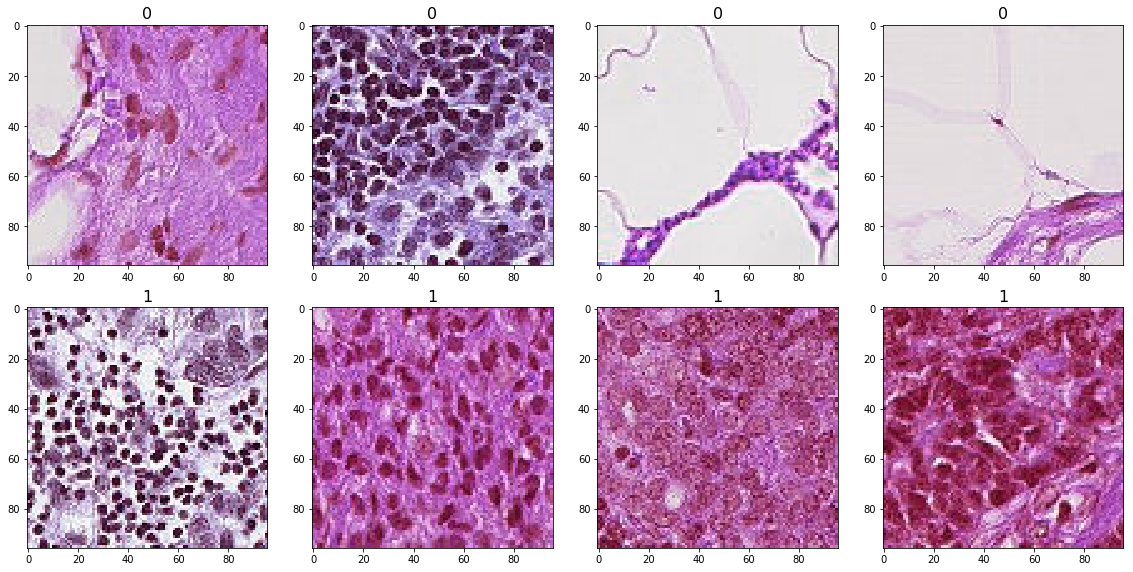

In [8]:
IMAGE_PATH = '../input/histopathologic-cancer-detection/train/' 

draw_category_images('label',4, df_data, IMAGE_PATH)

### Create the Train and Val Sets

In [9]:
df_data.head()

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0



Reducing the number of samples in class 0.

In [10]:

df_0 = df_data[df_data['label'] == 0].sample(SAMPLE_SIZE, random_state = 101)

df_1 = df_data[df_data['label'] == 1].sample(SAMPLE_SIZE, random_state = 101)


df_data = pd.concat([df_0, df_1], axis=0).reset_index(drop=True)

df_data = shuffle(df_data)

df_data['label'].value_counts()

1    80000
0    80000
Name: label, dtype: int64

In [11]:
df_data.head()

,id,label
107459,dd79ff11333c3d9f91afe90aa9dbb891c385e74a,1
88068,2cf9a06a177c27e754d8bc368cbe622e1671ae78,1
37478,00ba015bf839a6762c1f0fc45114c3499c9db294,0
5470,bae28bc026fdc62b14a63bfcd61e5b6deb914320,0
138898,c424c75c639b5807317915eb8aa7071cf3849607,1


In [12]:



y = df_data['label']

df_train, df_val = train_test_split(df_data, test_size=0.10, random_state=101, stratify=y)

print(df_train.shape)
print(df_val.shape)

(144000, 2)
(16000, 2)


In [13]:
df_train['label'].value_counts()

1    72000
0    72000
Name: label, dtype: int64

In [14]:
df_val['label'].value_counts()

1    8000
0    8000
Name: label, dtype: int64

### Creating a Directory Structure

In [15]:

base_dir = 'base_dir'
os.mkdir(base_dir)




train_dir = os.path.join(base_dir, 'train_dir')
os.mkdir(train_dir)


val_dir = os.path.join(base_dir, 'val_dir')
os.mkdir(val_dir)




no_met_tissue = os.path.join(train_dir, 'a_no_met_tissue')
os.mkdir(no_met_tissue)
has_met_tissue = os.path.join(train_dir, 'b_has_met_tissue')
os.mkdir(has_met_tissue)



no_met_tissue = os.path.join(val_dir, 'a_no_met_tissue')
os.mkdir(no_met_tissue)
has_met_tissue = os.path.join(val_dir, 'b_has_met_tissue')
os.mkdir(has_met_tissue)



In [16]:

os.listdir('base_dir/train_dir')

['a_no_met_tissue', 'b_has_met_tissue']

### Transfer the images into the folders

In [17]:

df_data.set_index('id', inplace=True)

In [18]:



train_list = list(df_train['id'])
val_list = list(df_val['id'])





for image in train_list:

    fname_tif = image + '.tif'

    target = df_data.loc[image,'label']
    
   
    if target == 0:
        label = 'a_no_met_tissue'
    if target == 1:
        label = 'b_has_met_tissue'
    

    src = os.path.join('../input/histopathologic-cancer-detection/train', fname_tif)
   
    fname_png = image + '.png'
 
    dst = os.path.join(train_dir, label, fname_png)

    
   
    cv2_image = cv2.imread(src)
   
    cv2.imwrite(dst, cv2_image)
 



for image in val_list:
    
  
    fname_tif = image + '.tif'
  
    target = df_data.loc[image,'label']

    if target == 0:
        label = 'a_no_met_tissue'
    if target == 1:
        label = 'b_has_met_tissue'
    
    src = os.path.join('../input/histopathologic-cancer-detection/train', fname_tif)

    fname_png = image + '.png'
 
    dst = os.path.join(val_dir, label, fname_png)

    

    cv2_image = cv2.imread(src)
    
    cv2.imwrite(dst, cv2_image)


   

In [19]:


print(len(os.listdir('base_dir/train_dir/a_no_met_tissue')))
print(len(os.listdir('base_dir/train_dir/b_has_met_tissue')))


72000
72000


In [20]:


print(len(os.listdir('base_dir/val_dir/a_no_met_tissue')))
print(len(os.listdir('base_dir/val_dir/b_has_met_tissue')))


8000
8000


### Set Up the Generators

In [21]:
train_path = 'base_dir/train_dir'
valid_path = 'base_dir/val_dir'
test_path = '../input/test'

num_train_samples = len(df_train)
num_val_samples = len(df_val)
train_batch_size = 10
val_batch_size = 10


train_steps = np.ceil(num_train_samples / train_batch_size)
val_steps = np.ceil(num_val_samples / val_batch_size)

In [22]:
datagen = ImageDataGenerator(rescale=1.0/255)

train_gen = datagen.flow_from_directory(train_path,
                                        target_size=(IMAGE_SIZE,IMAGE_SIZE),
                                        batch_size=train_batch_size,
                                        class_mode='categorical')

val_gen = datagen.flow_from_directory(valid_path,
                                        target_size=(IMAGE_SIZE,IMAGE_SIZE),
                                        batch_size=val_batch_size,
                                        class_mode='categorical')


test_gen = datagen.flow_from_directory(valid_path,
                                        target_size=(IMAGE_SIZE,IMAGE_SIZE),
                                        batch_size=1,
                                        class_mode='categorical',
                                        shuffle=False)

Found 144000 images belonging to 2 classes.
Found 16000 images belonging to 2 classes.
Found 16000 images belonging to 2 classes.


### Model Architecture¶

In [23]:


kernel_size = (3,3)
pool_size= (2,2)
first_filters = 32
second_filters = 64
third_filters = 128

dropout_conv = 0.3
dropout_dense = 0.3


model = Sequential()
model.add(Conv2D(first_filters, kernel_size, activation = 'relu', input_shape = (96, 96, 3)))
model.add(Conv2D(first_filters, kernel_size, activation = 'relu'))
model.add(Conv2D(first_filters, kernel_size, activation = 'relu'))
model.add(MaxPooling2D(pool_size = pool_size)) 
model.add(Dropout(dropout_conv))

model.add(Conv2D(second_filters, kernel_size, activation ='relu'))
model.add(Conv2D(second_filters, kernel_size, activation ='relu'))
model.add(Conv2D(second_filters, kernel_size, activation ='relu'))
model.add(MaxPooling2D(pool_size = pool_size))
model.add(Dropout(dropout_conv))

model.add(Conv2D(third_filters, kernel_size, activation ='relu'))
model.add(Conv2D(third_filters, kernel_size, activation ='relu'))
model.add(Conv2D(third_filters, kernel_size, activation ='relu'))
model.add(MaxPooling2D(pool_size = pool_size))
model.add(Dropout(dropout_conv))

model.add(Flatten())
model.add(Dense(256, activation = "relu"))
model.add(Dropout(dropout_dense))
model.add(Dense(2, activation = "softmax"))

model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 94, 94, 32)        896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 92, 92, 32)        9248      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 90, 90, 32)        9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 45, 45, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 43, 43, 64)        18496     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 41, 41, 64)        36928     
__________

### Train the Model

In [24]:
model.compile(Adam(lr=0.0001), loss='binary_crossentropy', 
              metrics=['accuracy'])

In [25]:

print(val_gen.class_indices)

{'a_no_met_tissue': 0, 'b_has_met_tissue': 1}


In [26]:
filepath = "model.h5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, 
                             save_best_only=True, mode='max')

reduce_lr = ReduceLROnPlateau(monitor='val_acc', factor=0.5, patience=2, 
                                   verbose=1, mode='max', min_lr=0.00001)
                              
                              
callbacks_list = [checkpoint, reduce_lr]

history = model.fit_generator(train_gen, steps_per_epoch=train_steps, 
                    validation_data=val_gen,
                    validation_steps=val_steps,
                    epochs=20, verbose=1,
                   callbacks=callbacks_list)

Epoch 1/20
 7502/14400 [==============>...............] - ETA: 1:23:44 - loss: 0.4584 - acc: 0.7870

KeyboardInterrupt: 

### Evaluate the model using the val set

In [ ]:

model.metrics_names

In [ ]:


model.load_weights('model.h5')

val_loss, val_acc = \
model.evaluate_generator(test_gen, 
                        steps=len(df_val))

print('val_loss:', val_loss)
print('val_acc:', val_acc)

### Plot the Training Curves

In [ ]:


import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss', color='red')
plt.title('Training and validation loss')
plt.legend()
plt.figure()

plt.plot(epochs, acc, label='Training acc')
plt.plot(epochs, val_acc, label='Validation acc', color='red')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

### Make a prediction on the val set
We need these predictions to calculate the AUC score, print the Confusion Matrix and calculate the F1 score.

In [ ]:

predictions = model.predict_generator(test_gen, steps=len(df_val), verbose=1)

In [ ]:
predictions.shape

In [ ]:

test_gen.class_indices

In [ ]:


df_preds = pd.DataFrame(predictions, columns=['no_met_tissue', 'has_met_tissue'])

df_preds.head()

In [ ]:

y_true = test_gen.classes


y_pred = df_preds['has_met_tissue']


In [ ]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_true, y_pred)

In [ ]:

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

In [ ]:


test_labels = test_gen.classes

In [ ]:
test_labels.shape

In [ ]:

cm = confusion_matrix(test_labels, predictions.argmax(axis=1))

In [ ]:

test_gen.class_indices

In [ ]:

cm_plot_labels = ['no_met_tissue', 'has_met_tissue']

plot_confusion_matrix(cm, cm_plot_labels, title='Confusion Matrix')

In [ ]:
from sklearn.metrics import classification_report

y_pred_binary = predictions.argmax(axis=1)

report = classification_report(y_true, y_pred_binary, target_names=cm_plot_labels)

print(report)
